##Dataset Loading

In [2]:
!unzip "/content/Datasets.zip"

Archive:  /content/Datasets.zip
   creating: Datasets/
   creating: Datasets/annotations/
  inflating: Datasets/annotations/test_annotations.coco.json  
  inflating: Datasets/annotations/train_annotations.coco.json  
  inflating: Datasets/annotations/valid_annotations.coco.json  
   creating: Datasets/test/
  inflating: Datasets/test/IMG-106_jpg.rf.346cd9baa4f44c9395358966253c3abd.jpg  
  inflating: Datasets/test/IMG-113_jpg.rf.06da4785a8cfeda2925941fe0eda992e.jpg  
  inflating: Datasets/test/IMG-119_jpg.rf.02948e84d2c80d566decd4fcab67470f.jpg  
  inflating: Datasets/test/IMG-11_jpg.rf.c0264d78bd908863e9ae24060f16955d.jpg  
  inflating: Datasets/test/IMG-123_jpg.rf.3b8e8ea31c2e52c6303061a727acba36.jpg  
  inflating: Datasets/test/IMG-124_jpg.rf.ebe58dd366dd2b5e99a962e7cc00576c.jpg  
  inflating: Datasets/test/IMG-12_jpg.rf.8100973c501d69747e352cefcfb801f5.jpg  
  inflating: Datasets/test/IMG-137_jpg.rf.c4c822e2aa509c82f141a5d941cb1fe9.jpg  
  inflating: Datasets/test/IMG-144_jpg.rf.568

##Custom Dataset for the model

In [3]:
import os
import json
import numpy as np
from PIL import Image, ImageDraw
import torch
from torch.utils.data import Dataset
from torchvision.transforms import functional as F


class CustomDataset(Dataset):
    def __init__(self, json_path, images_dir, transform=None, target_transform=None):

        with open(json_path, 'r') as f:
            data = json.load(f)

        self.images_dir = images_dir
        self.transform = transform
        self.target_transform = target_transform
        self.image_data = {img['id']: img for img in data['images']}
        self.annotations = data['annotations']
        self.categories = {cat['id']: cat['name'] for cat in data['categories']}

    def __len__(self):
        return len(self.image_data)

    def __getitem__(self, idx):

        image_info = list(self.image_data.values())[idx]
        image_path = os.path.join(self.images_dir, image_info['file_name'])
        image = Image.open(image_path).convert('RGB')


        mask = self.generate_mask(image_info['id'], image_info['height'], image_info['width'])

        # Apply transformations
        if self.transform:
            image = self.transform(image)
        if self.target_transform:
            mask = self.target_transform(mask)

        return image, mask

    def generate_mask(self, image_id, height, width):

        mask = np.zeros((height, width), dtype=np.uint8)
        annotations = [ann for ann in self.annotations if ann['image_id'] == image_id]

        for annotation in annotations:
            category_id = annotation['category_id']
            for polygon in annotation['segmentation']:
                poly = np.array(polygon).reshape((-1, 2))
                mask = self.draw_polygon(mask, poly, category_id)

        return Image.fromarray(mask)

    @staticmethod
    def draw_polygon(mask, polygon, category_id):

        mask_image = Image.fromarray(mask)
        draw = ImageDraw.Draw(mask_image)
        draw.polygon([tuple(point) for point in polygon], fill=category_id)
        return np.array(mask_image)

Normalization and Augmentation

In [4]:
from torchvision import transforms
import torch

# Define transformations for the images
image_transform = transforms.Compose([
    transforms.Resize((512, 512)),
    transforms.ToTensor(),
])

# Define transformations for the masks
def mask_transform(mask):
    # Resize the mask using nearest-neighbor interpolation
    mask = F.resize(mask, (512, 512), interpolation=Image.NEAREST)

    mask = torch.as_tensor(np.array(mask, dtype=np.uint8))
    return mask


In [5]:
from torchvision import transforms
from torch.utils.data import DataLoader
# Paths for images and annotations
train_image_dir = "/content/Datasets/train"
val_image_dir = "/content/Datasets/valid"
test_image_dir = "/content/Datasets/test"
train_annotation_path = "/content/Datasets/annotations/train_annotations.coco.json"
val_annotation_path = "/content/Datasets/annotations/valid_annotations.coco.json"
test_annotation_path = "/content/Datasets/annotations/test_annotations.coco.json"

# Create datasets
train_dataset = CustomDataset(
    json_path=train_annotation_path,
    images_dir=train_image_dir,
    transform=image_transform,
    target_transform=mask_transform
)

val_dataset = CustomDataset(
    json_path=val_annotation_path,
    images_dir=val_image_dir,
    transform=image_transform,
    target_transform=mask_transform
)

test_dataset = CustomDataset(
    json_path=test_annotation_path,
    images_dir=test_image_dir,
    transform=image_transform,
    target_transform=mask_transform
)

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

##DeeplabV3 Model

In [6]:
import torch.nn as nn
from torchvision.models.segmentation import deeplabv3_resnet50, DeepLabV3_ResNet50_Weights

# Number of classes: 2 foreground classes + 1 background class
num_classes = 3

# Loading the model with pretrained weights
weights = DeepLabV3_ResNet50_Weights.DEFAULT
model = deeplabv3_resnet50(weights=weights)


model.classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1, 1))
model.aux_classifier[4] = nn.Conv2d(256, num_classes, kernel_size=(1, 1))

# Freeze all layers
for param in model.parameters():
    param.requires_grad = False

# Unfreeze only the classifier and aux_classifier layers
for param in model.classifier.parameters():
    param.requires_grad = True
for param in model.aux_classifier.parameters():
    param.requires_grad = True


Downloading: "https://download.pytorch.org/models/deeplabv3_resnet50_coco-cd0a2569.pth" to /root/.cache/torch/hub/checkpoints/deeplabv3_resnet50_coco-cd0a2569.pth
100%|██████████| 161M/161M [00:00<00:00, 201MB/s]


##Training & Finetuning




1.   Calculating the Training and Validation Loss
2.   Selecting the best hyperparameter




In [7]:
import torch
from torch.optim import Adam
from torch.nn import CrossEntropyLoss
from tqdm import tqdm

# Define hyperparameter sets
learning_rate = [1e-4, 1e-3]
weight_decay = [1e-4]
num_epochs = 10


device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)


criterion = CrossEntropyLoss()

# Store results for each configuration
config_results = []

# Training and validation functions
def train_one_epoch(model, dataloader, optimizer, criterion, device):
    model.train()
    running_loss = 0.0
    for images, masks in tqdm(dataloader, desc="Training", leave=False):
        images = images.to(device)
        masks = masks.to(device, dtype=torch.long)

        optimizer.zero_grad()
        outputs = model(images)['out']
        loss = criterion(outputs, masks)
        loss.backward()


        optimizer.step()

        running_loss += loss.item()
    return running_loss / len(dataloader)

def validate_one_epoch(model, dataloader, criterion, device):
    model.eval()
    running_loss = 0.0
    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="Validation", leave=False):
            images = images.to(device)
            masks = masks.to(device, dtype=torch.long)

            outputs = model(images)['out']
            loss = criterion(outputs, masks)

            running_loss += loss.item()
    return running_loss / len(dataloader)


# Training and validation loops for each hyperparameter configuration
for lr in learning_rate:
    for wd in weight_decay:
        print(f"\nTraining with Learning Rate: {lr}, Weight Decay: {wd}\n")


        trainable_params = list(model.classifier.parameters()) + list(model.aux_classifier.parameters())
        optimizer = Adam(trainable_params, lr=lr, weight_decay=wd)

        train_losses = []
        val_losses = []

        for epoch in range(num_epochs):
            print(f"Epoch {epoch + 1}/{num_epochs}")

            train_loss = train_one_epoch(model, train_loader, optimizer, criterion, device)
            val_loss = validate_one_epoch(model, val_loader, criterion, device)

            train_losses.append(train_loss)
            val_losses.append(val_loss)

            print(f"Train Loss: {train_loss:.4f}, Validation Loss: {val_loss:.4f}")


        config_results.append({
            "learning_rate": lr,
            "weight_decay": wd,
            "train_losses": train_losses,
            "val_losses": val_losses,
            "final_train_loss": train_losses[-1],
            "final_val_loss": val_losses[-1]
        })

# Save the best configuration's model
best_config = min(config_results, key=lambda x: x["final_val_loss"])
print(f"\nBest Configuration: Learning Rate = {best_config['learning_rate']}, Weight Decay = {best_config['weight_decay']}")
torch.save(model.state_dict(), f"deeplabv3_best_model.pth")


Training with Learning Rate: 0.0001, Weight Decay: 0.0001

Epoch 1/10


Train Loss: 0.8572, Validation Loss: 1.0111
Epoch 2/10


Train Loss: 0.5847, Validation Loss: 0.6128
Epoch 3/10


Train Loss: 0.4636, Validation Loss: 0.4829
Epoch 4/10


Train Loss: 0.3754, Validation Loss: 0.4465
Epoch 5/10


Train Loss: 0.3411, Validation Loss: 0.4229
Epoch 6/10


Train Loss: 0.3067, Validation Loss: 0.4467
Epoch 7/10


Train Loss: 0.2651, Validation Loss: 0.4314
Epoch 8/10


Train Loss: 0.2408, Validation Loss: 0.4156
Epoch 9/10


Train Loss: 0.2435, Validation Loss: 0.4343
Epoch 10/10


Train Loss: 0.2094, Validation Loss: 0.4259

Training with Learning Rate: 0.001, Weight Decay: 0.0001

Epoch 1/10


Train Loss: 0.5355, Validation Loss: 0.6191
Epoch 2/10


Train Loss: 0.3593, Validation Loss: 0.4491
Epoch 3/10


Train Loss: 0.3432, Validation Loss: 0.3924
Epoch 4/10


Train Loss: 0.2832, Validation Loss: 0.4155
Epoch 5/10


Train Loss: 0.2567, Validation Loss: 0.4261
Epoch 6/10


Train Loss: 0.2074, Validation Loss: 0.4183
Epoch 7/10


Train Loss: 0.2018, Validation Loss: 0.4491
Epoch 8/10


Train Loss: 0.1946, Validation Loss: 0.4168
Epoch 9/10


Train Loss: 0.1796, Validation Loss: 0.5810
Epoch 10/10


Train Loss: 0.2004, Validation Loss: 0.4546

Best Configuration: Learning Rate = 0.0001, Weight Decay = 0.0001


Plotting the Graph

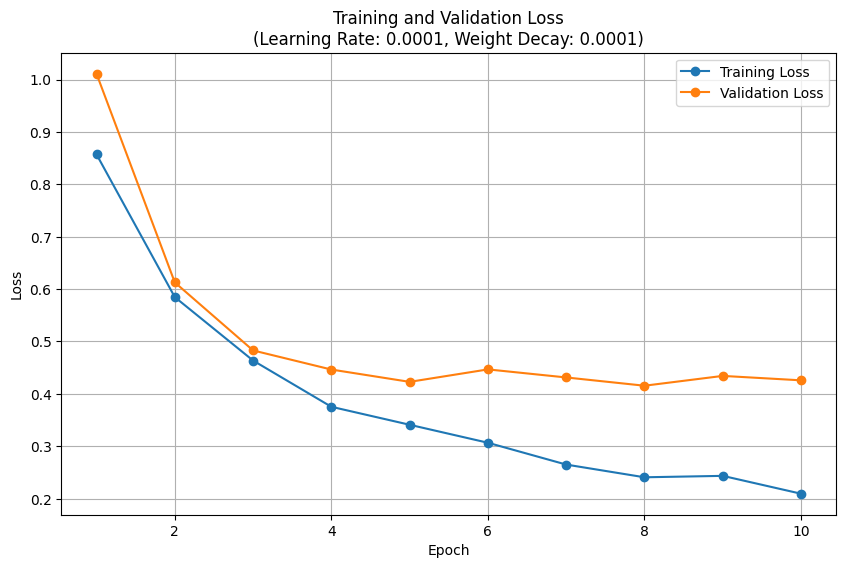

In [8]:
import matplotlib.pyplot as plt


best_train_losses = best_config["train_losses"]
best_val_losses = best_config["val_losses"]

# Plot the losses
plt.figure(figsize=(10, 6))
plt.plot(range(1, len(best_train_losses) + 1), best_train_losses, label="Training Loss", marker='o')
plt.plot(range(1, len(best_val_losses) + 1), best_val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title(f"Training and Validation Loss\n(Learning Rate: {best_config['learning_rate']}, Weight Decay: {best_config['weight_decay']})")
plt.legend()
plt.grid()
plt.show()


#Visualizing the Prediction

<ipython-input-9-bcd80d1c5d4b>:64: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("deeplabv3_best_model.pth"))


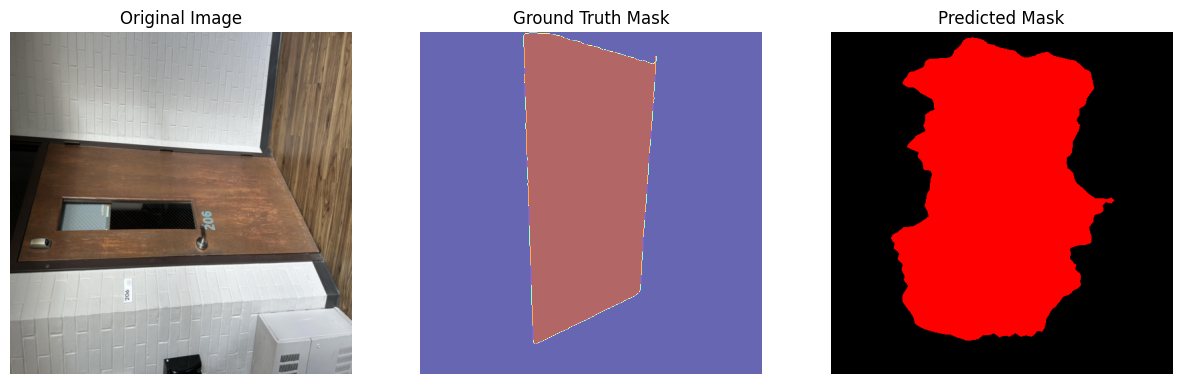

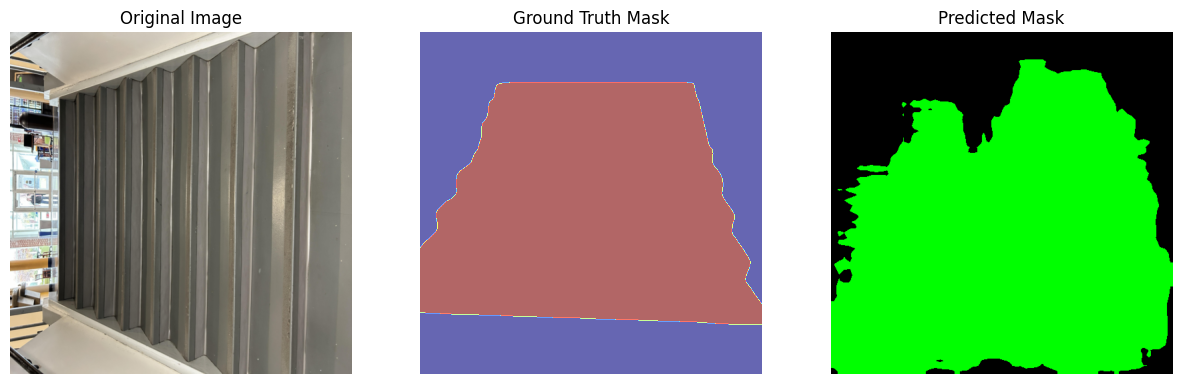

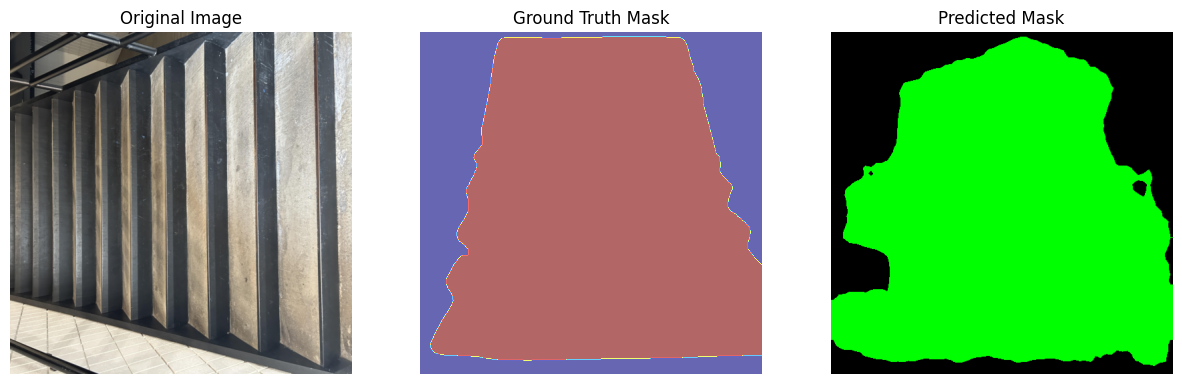

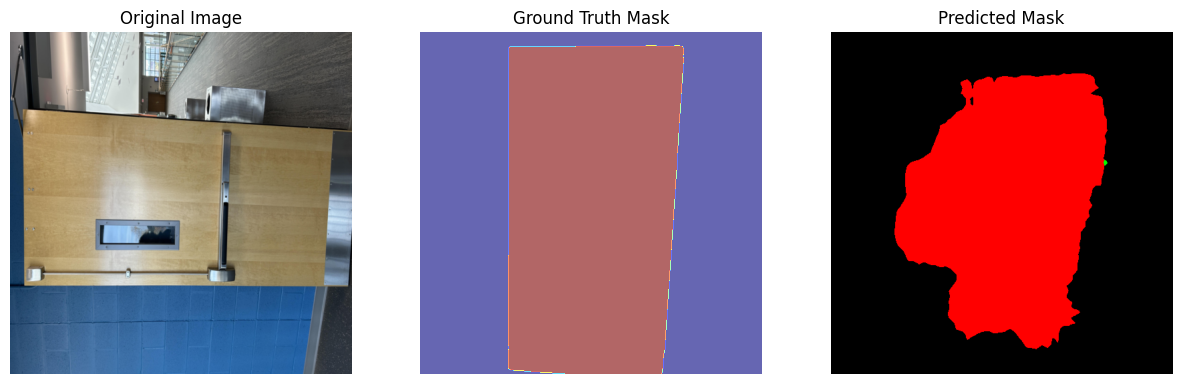

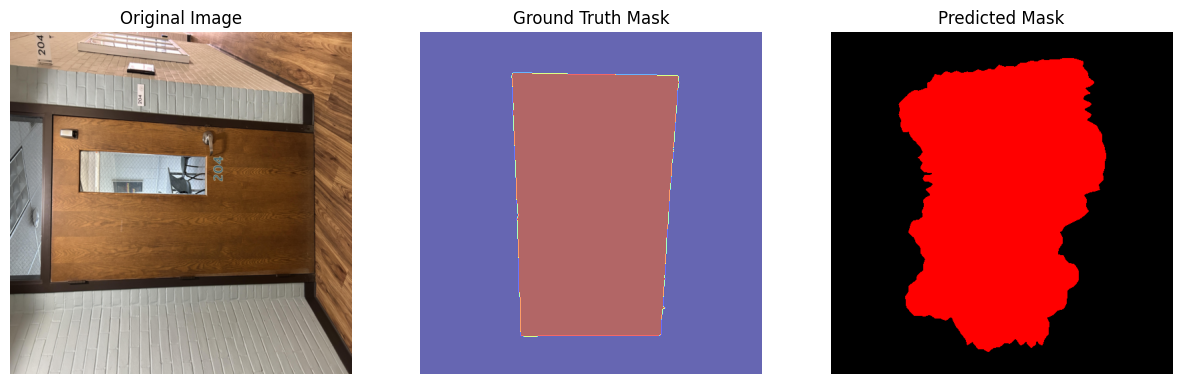

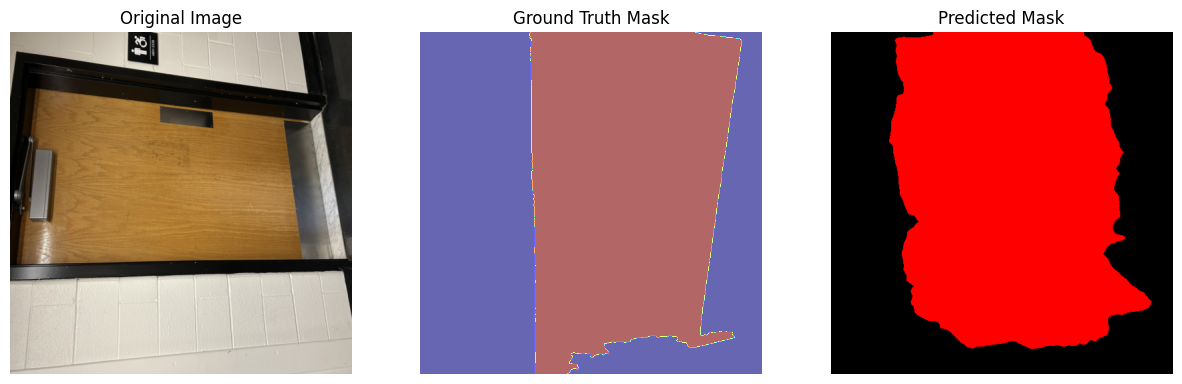

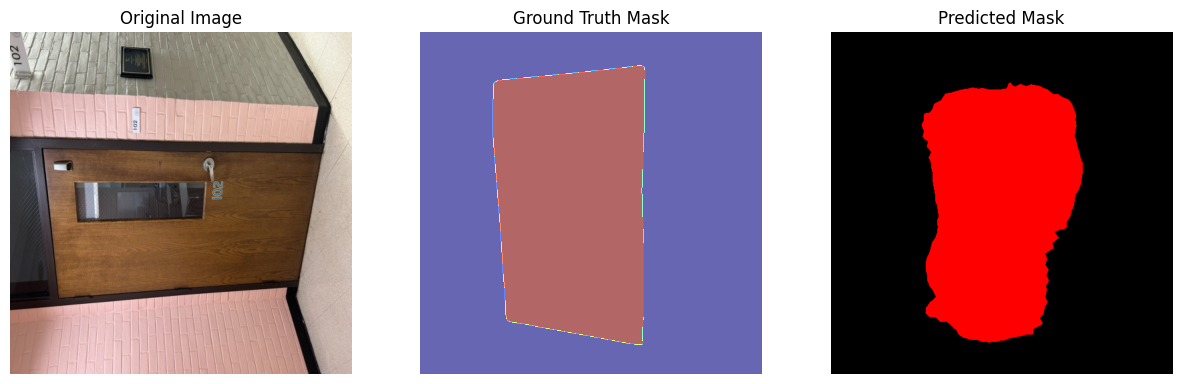

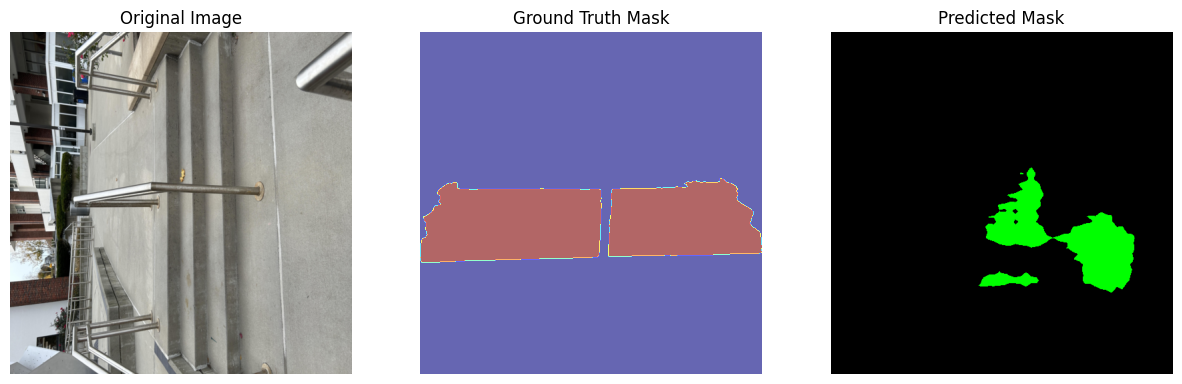

In [9]:
import matplotlib.pyplot as plt
import numpy as np

def apply_color_mapping(mask, color_mapping):

    h, w = mask.shape
    colored_mask = np.zeros((h, w, 3), dtype=np.uint8)

    for class_id, color in color_mapping.items():
        colored_mask[mask == class_id] = color

    return colored_mask

def visualize_prediction(model, dataloader, device):

    color_mapping = {
        0: (0, 0, 0),        # background: black
        1: (255, 0, 0),      # Door: red
        2: (0, 255, 0),      # Stair: green
    }

    model.eval()
    images, masks = next(iter(dataloader))
    images = images.to(device)
    masks = masks.numpy()

    with torch.no_grad():
        outputs = model(images)['out']
        predictions = torch.argmax(outputs, dim=1).cpu().numpy()

    # Visualize the original image, ground truth mask, and predicted mask
    batch_size = images.shape[0]
    for i in range(batch_size):
        image = images[i].cpu().permute(1, 2, 0).numpy()
        ground_truth = masks[i]
        prediction = predictions[i]


        prediction_colored = apply_color_mapping(prediction, color_mapping)

        plt.figure(figsize=(15, 5))

        # Original image
        plt.subplot(1, 3, 1)
        plt.imshow(image)
        plt.title("Original Image")
        plt.axis("off")

        # Ground truth mask
        plt.subplot(1, 3, 2)
        plt.imshow(ground_truth, cmap="jet", alpha=0.6)
        plt.title("Ground Truth Mask")
        plt.axis("off")

        # Predicted mask
        plt.subplot(1, 3, 3)
        plt.imshow(prediction_colored)
        plt.title("Predicted Mask")
        plt.axis("off")

        plt.show()

# Loading the fine-tuned model
model.load_state_dict(torch.load("deeplabv3_best_model.pth"))
model = model.to(device)

# Visualizing predictions
visualize_prediction(
    model=model,
    dataloader=val_loader,
    device=device
)


Calculating MIoU, Mean Accuracy and Pixel Accuracy

In [10]:
import numpy as np
from tqdm import tqdm

def calculate_metrics(pred, target, num_classes):
    ious = []
    accuracies = []
    total_pixels = target.size
    correct_pixels = (pred == target).sum()

    for class_id in range(num_classes):
        pred_class = (pred == class_id)
        target_class = (target == class_id)

        intersection = np.logical_and(pred_class, target_class).sum()
        union = np.logical_or(pred_class, target_class).sum()
        class_pixels = target_class.sum()


        if union == 0:
            ious.append(float('nan'))
        else:
            ious.append(intersection / union)


        if class_pixels == 0:
            accuracies.append(float('nan'))
        else:
            accuracies.append(intersection / class_pixels)

    mean_iou = np.nanmean(ious)
    mean_accuracy = np.nanmean(accuracies)
    pixel_accuracy = correct_pixels / total_pixels

    return {
        "ious": ious,
        "mean_iou": mean_iou,
        "class_accuracies": accuracies,
        "mean_accuracy": mean_accuracy,
        "pixel_accuracy": pixel_accuracy,
    }

def evaluate_metrics(model, dataloader, device, num_classes):
    model.eval()
    total_ious = []
    total_accuracies = []
    total_pixel_accuracy = []

    with torch.no_grad():
        for images, masks in tqdm(dataloader, desc="Evaluating Metrics"):
            images = images.to(device)
            masks = masks.numpy()
            outputs = model(images)['out']
            predictions = torch.argmax(outputs, dim=1).cpu().numpy()


            for pred, target in zip(predictions, masks):
                metrics = calculate_metrics(pred, target, num_classes)
                total_ious.append(metrics["mean_iou"])
                total_accuracies.append(metrics["mean_accuracy"])
                total_pixel_accuracy.append(metrics["pixel_accuracy"])


    overall_mean_iou = np.nanmean(total_ious)
    overall_mean_accuracy = np.nanmean(total_accuracies)
    overall_pixel_accuracy = np.nanmean(total_pixel_accuracy)

    return {
        "mean_iou": overall_mean_iou,
        "mean_accuracy": overall_mean_accuracy,
        "pixel_accuracy": overall_pixel_accuracy,
    }


num_classes = len(train_dataset.categories)


metrics = evaluate_metrics(model, val_loader, device, num_classes)
print("\n")
print(f"Mean IoU: {metrics['mean_iou']:.4f}")
print(f"Mean Accuracy: {metrics['mean_accuracy']:.4f}")
print(f"Pixel Accuracy: {metrics['pixel_accuracy']:.4f}")


Evaluating Metrics: 100%|██████████| 3/3 [00:03<00:00,  1.15s/it]



Mean IoU: 0.6276
Mean Accuracy: 0.8090
Pixel Accuracy: 0.8299
